# Useful functions

In [1]:
#get_polygons_coordinates(geometry)

In [2]:
# Project WGS84 CRS geometry to UTM CRS geometry
#geometry_proj, crs_proj = project_geometry(polygon)

#Project UTM CRS geometry to WGS84 CRS geometry
#geometry, _ = project_geometry(geometry_proj_consolidated_subdivided, crs=crs_proj, to_latlong=True)

## Warto sprawdzić to żeby pociać finalny prostokąt na kafelki PV

In [3]:
#quadrat_cut_geometry(geometry, quadrat_width, min_num=3, buffer_amount=1e-9):

### Export data to CSV if needed

In [4]:
#farmland_footprints.to_csv(r'C:\Users\daniel.stankiewicz\Desktop\OSM_PVfarmPotential-master\CSV files\farmland_footprints.csv')

### Import necessary modules

In [5]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import maxrect
import cvxpy
#from maxrect import get_maximal_rectangle, pts_to_leq
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

### Define all helper functions

In [6]:
def download_footprints(west, south, east, north,footprints_type = 'landuse'):
    polygon = ox.bbox_to_poly(north,south,east,west)
    footprints_gdf = ox.footprints_from_polygon(polygon,footprint_type=footprints_type)
    
    return polygon, footprints_gdf


def filter_footprints(footprints_gdf, footprints_type = 'landuse', chosenFootprints = ['farmland','forest','grass','meadow']):
    filtered_gdf = footprints_gdf.loc[footprints_gdf[footprints_type].isin(chosenFootprints)]
    
    return filtered_gdf


#def show_footprints(footprints_gdf):
#    fig,ax = ox.plot_footprints(footprints_gdf)


### User input - bounding box required

In [7]:
#west, south, east, north = 18.5685998807,50.8595154681,18.5807532856,50.8629457573
west, south, east, north = 21.8400832534,53.5136264306,21.8566314104,53.518393078
#west, south, east, north = 21.890483,53.51505,21.910353,53.51971
#west, south, east, north = 20.7724649696,52.2912388736,20.7842924401,52.2959529584

### Create polygon from bbox and download footprints for given region

In [8]:
poly, footprints_landuse_gdf = download_footprints(west,south,east,north)
filtered_footprints_landuse_gdf = filter_footprints(footprints_landuse_gdf)

# TO DELETE START 

###### Both examples are coordinate systems. The difference is that WGS 84 is a geographic coordinate system, and UTM is a projected coordinate system. Geographic coordinate systems are based on a spheroid and utilize angular units (degrees). Projected coordinate systems are based on a plane (the spheroid projected onto a 2D surface) and utilize linear units (feet, meters, etc.).

In [9]:
filtered_footprints_landuse_gdf.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [10]:
ox.is_crs_utm(filtered_footprints_landuse_gdf.crs)

False

# TO DELETE END

In [11]:
print("Polygon type:\n{0}\n\nList of related footprints downloaded from given area:\n{1}\n\nList of related footprints after filtering:\n{2}".format(type(poly),footprints_landuse_gdf.landuse.unique(),filtered_footprints_landuse_gdf.landuse.unique()))

Polygon type:
<class 'shapely.geometry.polygon.Polygon'>

List of related footprints downloaded from given area:
['forest' 'meadow']

List of related footprints after filtering:
['forest' 'meadow']


### Plot each type of downloaded footprints

In [12]:
forest_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='forest']
farmland_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='farmland']
meadow_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='meadow']
grass_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='grass']

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


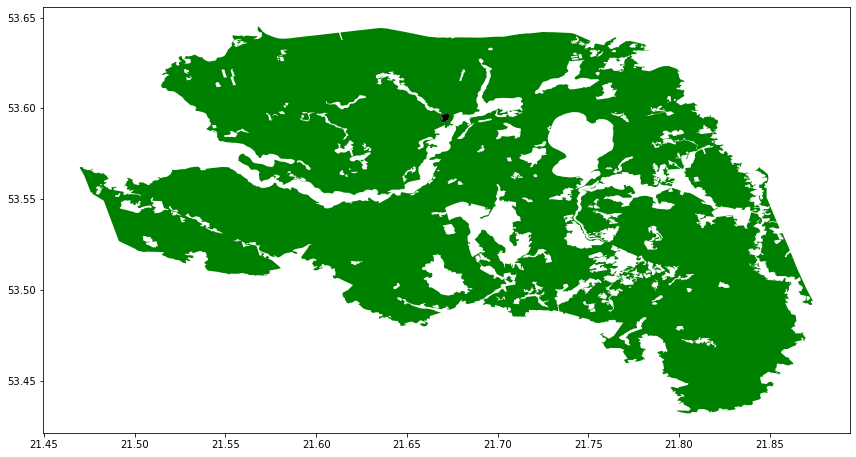

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot forests
forest_footprints.plot(ax=ax, facecolor='green')

# Plot farmlands
farmland_footprints.plot(ax=ax, facecolor="blue")

# Plot meadows
meadow_footprints.plot(ax=ax, facecolor="black")

# Plot grass
grass_footprints.plot(ax=ax, facecolor='yellow')

plt.tight_layout()

### Make an intersection betweeen downloaded relation footprints and given boundry box

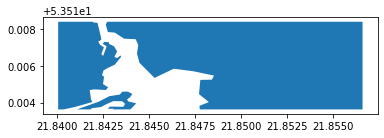

In [14]:
landuse_bbox = filtered_footprints_landuse_gdf['geometry'].intersection(poly)
landuse_bbox_gdf = gpd.GeoDataFrame(geometry=landuse_bbox)
landuse_bbox_gdf = landuse_bbox_gdf[landuse_bbox_gdf.is_empty == False]
landuse_bbox_gdf.plot()

In [15]:
print("landuse_bbox_gdf is in format {0} \nand landuse_bbox is in format {1}".format(type(landuse_bbox_gdf),type(landuse_bbox)))

landuse_bbox_gdf is in format <class 'geopandas.geodataframe.GeoDataFrame'> 
and landuse_bbox is in format <class 'geopandas.geoseries.GeoSeries'>


### Create single polygon from intersected GeoDataFrame

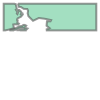

In [16]:
area_polygon = landuse_bbox_gdf.unary_union
area_polygon

### If area_polygon is MultiPolygon then pick single Polygon of biggest area for further processing

In [17]:
if isinstance(area_polygon, MultiPolygon):
    biggest_poly = 0
    multipoly = area_polygon
    for poly in list(multipoly):
        if(poly.area > biggest_poly):
            new_area_polygon = poly
            biggest_poly = poly.area
    area_polygon = new_area_polygon

In [18]:
area_polygon.area

5.219547019170943e-05

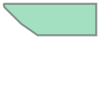

In [19]:
area_convexhull_polygon = area_polygon.convex_hull
area_convexhull_polygon

In [20]:
area_polygon.area

5.219547019170943e-05

In [21]:
print("Intersected poly is type of:\n{0}".format(area_polygon.type))

Intersected poly is type of:
Polygon


### Get largest rectangle area inside of convex Polygon

##### Monkey Patch of Solver picking and return statement of get_maximal_rectangle function from maxrect module

In [22]:
def modified_get_maximal_rectangle(coordinates):
    
    """
    Find the largest, inscribed, axis-aligned rectangle.
    :param coordinates:
        A list of of [x, y] pairs describing a closed, convex polygon.
    """

    coordinates = np.array(coordinates)
    x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
    y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

    scale = np.array([x_range, y_range])
    sc_coordinates = coordinates/scale

    poly = Polygon(sc_coordinates)
    inside_pt = (poly.representative_point().x,
                 poly.representative_point().y)

    A1, A2, B = maxrect.pts_to_leq(sc_coordinates)

    bl = cvxpy.Variable(2)
    tr = cvxpy.Variable(2)
    br = cvxpy.Variable(2)
    tl = cvxpy.Variable(2)
    obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
    constraints = [bl[0] == tl[0],
                   br[0] == tr[0],
                   tl[1] == tr[1],
                   bl[1] == br[1],
                   ]

    for i in range(len(B)):
        if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

        else:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

    prob = cvxpy.Problem(obj, constraints)
        
    try:
        solver='ECOS'
        prob.solve(solver=solver, verbose=False)
    except:
        try:
            solver='ECOS_BB'
            prob.solve(solver=solver, verbose=False)
        except:
            try:
                solver='CVXOPT'
                prob.solve(solver=solver, verbose=False)
            except:
                try:
                    solver='OSQP'
                    prob.solve(solver=solver, verbose=False)
                except:
                    try:
                        solver='GLPK'
                        prob.solve(solver=solver, verbose=False)   
                    except:
                        try:
                            solver='GLPK_MI'
                            prob.solve(solver=solver, verbose=False)  
                        except:
                            solver='SCS'
                            prob.solve(solver=solver, verbose=False)  
    
    print('Used solver: {0}'.format(solver))
    bottom_left = np.array(bl.value).T * scale
    top_right = np.array(tr.value).T * scale

    return list(bottom_left), list(top_right)

#monkey patch function
maxrect.get_maximal_rectangle = modified_get_maximal_rectangle

In [23]:
def fit_plot_ranctangle_polygon(polygon):
    coordinates = list(polygon.exterior.coords)
    ll, ur = maxrect.get_maximal_rectangle(coordinates)
    calculated_coordinates = maxrect.rect2poly(ll,ur)
    
    poly_coordinates = Polygon(coordinates)
    poly_calculated = Polygon(calculated_coordinates)
    
    x,y = poly_coordinates.exterior.xy
    a,b = poly_calculated.exterior.xy
    
    plt.plot(x,y,color="red")
    plt.plot(a,b,color="blue")
    plt.plot()
    
    return poly_calculated

In [24]:
#coordinates = list(area_polygon.exterior.coords)
#ll, ur = maxrect.get_maximal_rectangle(coordinates)
#calculated_coordinates = maxrect.rect2poly(ll,ur)

In [25]:
#poly_coordinates = Polygon(coordinates)
#poly_calculated = Polygon(calculated_coordinates)

#x,y = poly_coordinates.exterior.xy
#a,b = poly_calculated.exterior.xy

In [26]:
#plt.plot(x,y,color="red")
#plt.plot(a,b,color="blue")
#plt.plot()

Used solver: ECOS


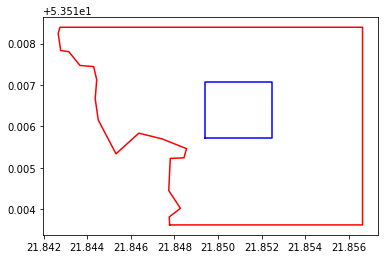

In [27]:
poly_calculated = fit_plot_ranctangle_polygon(area_polygon)

Used solver: ECOS


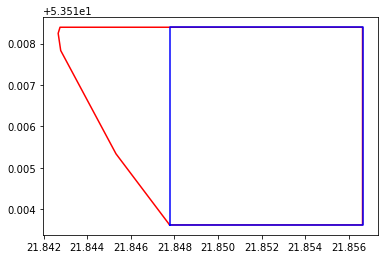

In [28]:
convexhull_poly_calculated = fit_plot_ranctangle_polygon(area_convexhull_polygon)

In [29]:
list(convexhull_poly_calculated.exterior.coords)

[(21.847782144056378, 53.51362641490376),
 (21.847782144056378, 53.51839295800414),
 (21.85663135249128, 53.51839295800414),
 (21.85663135249128, 53.51362641490376),
 (21.847782144056378, 53.51362641490376)]

In [30]:
type(convexhull_poly_calculated)

shapely.geometry.polygon.Polygon

In [ ]:
ox.get_polygons_coordinates(convexhull_poly_calculated)

In [ ]:
convexhull_poly_calculated_utm, crs_proj = ox.project_geometry(convexhull_poly_calculated)

In [ ]:
crs_proj

In [ ]:
default_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [ ]:
gdf = gpd.GeoDataFrame()
gdf

In [ ]:
gdf.crs = default_crs
gdf

In [ ]:
gdf.gdf_name = 'geometry to project'
gdf

In [ ]:
gdf['geometry'] = None
gdf

In [ ]:
gdf.loc[0, 'geometry'] = convexhull_poly_calculated
gdf

In [ ]:
gdf.crs

# TODO NEXT
## Algorithm for fitting PV rectangles into convexhull_poly_calculated

#### Step 1 -> jakie projection, funkcja żeby znaleźć relację między lat,log a metrami

#### Step 2 -> funkcja -> podaje wysokość i szerokość kafelka PV i dostaję kafelki wrysowane w prostokąt za pomocą PLT

###### 2.1_update -> przejdź z głównym prostokątem na UTM, wylicz szerokośc i wysokośc z .boundries i różnicy xmax-xmin i y analogicznie 

###### 2.2 -> dwie zmienne n i m, gdzie n to int(szerokość_prostokąta / szerokość_kafelka) , a m to int(wysokość_kafelka / wysokość_kafelka). Daje mi to ile kafelków wejdzie w szerokości i ile w wysokości

###### 2.4 -> weź min y i w pętli iteruj dodając wysokość kafelka m razy, analogicznie min x i w pętli dodawaj szerokość kafelka n razy 

###### 2.5 -> zrobić z każdej pary prostokąt i wrzucać je w pętli to tablicy kafelków

###### 2.6 -> plotting kafelków 

###### 2.7 -> Przejście na WGS84 lat/long

### Step 1

In [34]:
# Project WGS84 CRS geometry to UTM CRS geometry
utm_proj_convexhull_poly_calculated, crs_proj = ox.project_geometry(convexhull_poly_calculated)

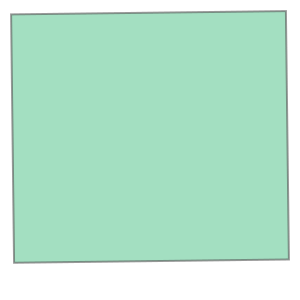

In [35]:
utm_proj_convexhull_poly_calculated

In [36]:
crs_proj

'+proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

##### Przed

In [37]:
convexhull_poly_calculated.bounds

(21.847782144056378, 53.51362641490376, 21.85663135249128, 53.51839295800414)

In [38]:
ox.get_polygons_coordinates(convexhull_poly_calculated)

['53.513626 21.847782 53.518393 21.847782 53.518393 21.856631 53.513626 21.856631 53.513626 21.847782']

##### Po

In [39]:
utm_proj_convexhull_poly_calculated.bounds

(556210.5767785513, 5929744.110666637, 556803.6687532738, 5930281.395723334)

In [40]:
ox.get_polygons_coordinates(utm_proj_convexhull_poly_calculated)

['5929744.110667 556216.885730 5930274.378503 556210.576779 5930281.395723 556797.293943 5929751.128243 556803.668753 5929744.110667 556216.885730']

In [ ]:
x,y = utm_proj_convexhull_poly_calculated.exterior.xy
#a,b = utm_proj_convexhull_poly_calculated.exterior.xy
    
plt.plot(x,y,color="red")
#plt.plot(a,b,color="blue")
plt.plot()

In [ ]:
x_range = max(x)-min(x)
y_range = max(y)-min(y)

In [ ]:
#zakładam szerokość kafelka (a) i wysokość kafelka (b) [m]
a = 2
b = 2

In [ ]:
n = int(x_range / a)
m = int(y_range / b)

In [ ]:
x_coords = []
y_coords = []

for z in range (n+1):
    x_coords.append(min(x) + a*z)

for z in range (m+1):
    y_coords.append(min(y) + b*z)

In [ ]:
n

In [ ]:
m

# test

In [31]:
#quadrat_cut_geometry(geometry, quadrat_width, min_num=3, buffer_amount=1e-9):

In [41]:
import math

In [68]:
geometry = utm_proj_convexhull_poly_calculated
quadrat_width = 200
min_num=3
buffer_amount=1e-9

In [69]:
# create n evenly spaced points between the min and max x and y bounds
west, south, east, north = geometry.bounds
x_num = math.ceil((east-west) / quadrat_width) + 1
y_num = math.ceil((north-south) / quadrat_width) + 1
x_points = np.linspace(west, east, num=max(x_num, min_num))
y_points = np.linspace(south, north, num=max(y_num, min_num))

In [70]:
west, south, east, north

(556210.5767785513, 5929744.110666637, 556803.6687532738, 5930281.395723334)

In [71]:
x_num

4

In [72]:
y_num

4

In [73]:
x_points

array([556210.57677855, 556408.27410346, 556605.97142837, 556803.66875327])

In [74]:
# create a quadrat grid of lines at each of the evenly spaced points
vertical_lines = [LineString([(x, y_points[0]), (x, y_points[-1])]) for x in x_points]
horizont_lines = [LineString([(x_points[0], y), (x_points[-1], y)]) for y in y_points]
lines = vertical_lines + horizont_lines

In [75]:
vertical_lines

In [76]:
horizont_lines

In [77]:
lines

In [78]:
# buffer each line to distance of the quadrat width divided by 1 billion,
# take their union, then cut geometry into pieces by these quadrats
buffer_size = quadrat_width * buffer_amount
lines_buffered = [line.buffer(buffer_size) for line in lines]
quadrats = unary_union(lines_buffered)
multipoly = geometry.difference(quadrats)

In [79]:
buffer_size

2.0000000000000002e-07

In [80]:
lines_buffered

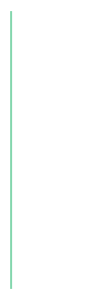

In [86]:
lines[1]

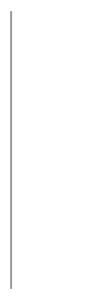

In [85]:
lines_buffered[1]

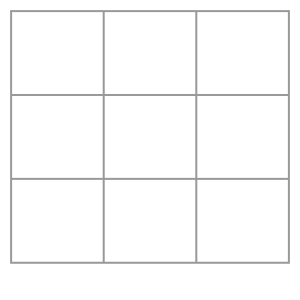

In [82]:
quadrats

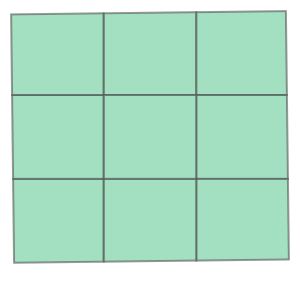

In [83]:
multipoly

In [87]:
type(multipoly)

shapely.geometry.multipolygon.MultiPolygon

In [88]:
len(multipoly)

9

In [89]:
multipoly.type

'MultiPolygon'

In [90]:
list(multipoly)

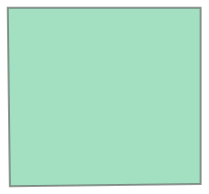

In [91]:
multipoly[0]

In [63]:
x_coordinates_array = []
y_coordinates_array = []

for poly in multipoly:
    x,y = poly.exterior.xy
    x_coordinates_array.append(x)
    y_coordinates_array.append(y)

### Step 2

###### substep 2.1

In [ ]:
coordinates = np.array(convexhull_poly_calculated.exterior.coords)
x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

###### substep 2.2